In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv('cookie_cats.csv')

## Context
As players progress through game, they encounter gates forcing them to wait before they can progress OR make in-app purchase. 

Analyze result of A/B test where the first gate in game is moved from level 30 to level 40. 

Analze impact on [player retention, game rounds]

<p>The data is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the test group (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first week after installation
<li><code>retention_1</code> - did the player come back and play 1 day after installing?</li>
<li><code>retention_7</code> - did the player come back and play 7 days after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. </p>

## Understanding our Dataset

In [2]:
df.head(3)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False


In [3]:
print('Two gates being tested are: ', df['version'].unique())

Two gates being tested are:  ['gate_30' 'gate_40']


In [4]:
df.groupby('version')['sum_gamerounds'].agg(['count','mean','median','std','max'])

,count,mean,median,std,max
version,,,,,
gate_30,44700,52.456264,17.0,256.716423,49854
gate_40,45489,51.298776,16.0,103.294416,2640


In [5]:
# Looks like there's a bug? a player played almost 50k rounds?
df[df['sum_gamerounds'] == 49854]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


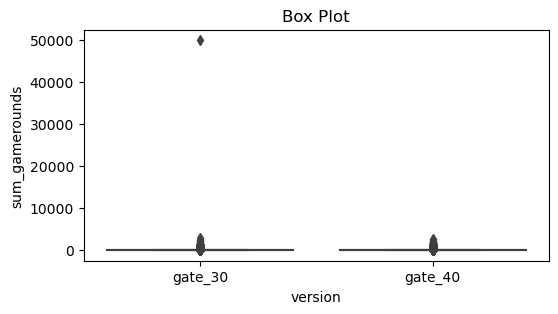

In [6]:
plt.figure(figsize=(6,3))
plt.title('Box Plot')
sns.boxplot(x=df['version'], y=df['sum_gamerounds'])
plt.show()

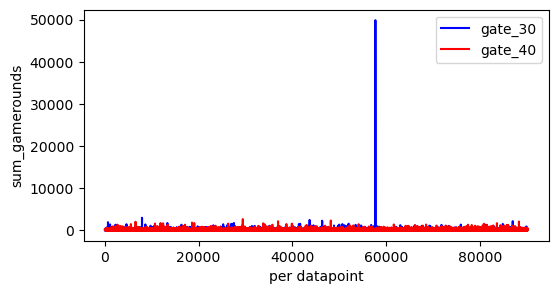

In [7]:
plt.figure(figsize=(6,3))
df[df['version']=='gate_30']['sum_gamerounds'].plot(color='blue', label='gate_30')
df[df['version']=='gate_40']['sum_gamerounds'].plot(color='red', label='gate_40')
plt.legend()
plt.ylabel('sum_gamerounds')
plt.xlabel('per datapoint')
plt.show()

From playing around our two variations, we understand that gate_30 version has an extreme value, we should address this before using our statistical models

### Addressing gate_30 outlier value

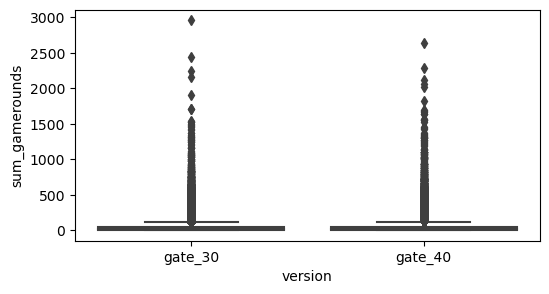

In [8]:
plt.figure(figsize=(6,3))
df_clean = df[df['sum_gamerounds'] < df['sum_gamerounds'].max()]
sns.boxplot(x=df_clean['version'], y=df_clean['sum_gamerounds'])
plt.show()

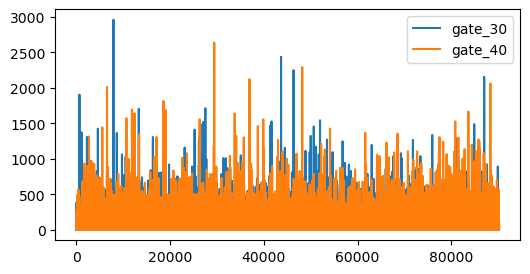

In [9]:
plt.figure(figsize=(6,3))
df_clean[df_clean['version']=='gate_30']['sum_gamerounds'].plot(label='gate_30')
df_clean[df_clean['version']=='gate_40']['sum_gamerounds'].plot(label='gate_40')
plt.legend()
plt.show()

Removing the 49854 extreme value, our plots are to scale

## A/B Testing

### Assumptions
- Check for Normality
- If Normal Distribution, check Homogeneity

### Steps
- Split & Define Samples
- Apply Shapiro Test for Normality, if both Normal -> Parametric, if both not Normal -> Non-Parametric tests
- If Non-Parametric apply Mann Whitney U Test directly
- If Parametric --> Levene Test for Homogeneity of variances
- If Parametric + Homogeneity of variances --> T-test
- If Parametric - Homogeneity of variances apply Welch Test


### Splitting 2 samples 

Mean for gate_30 = 51.342110561757536
Mean for gate_40 = 51.29877552814966
Means are pretty much similar, had to offset +1 on B mean to make it visually different


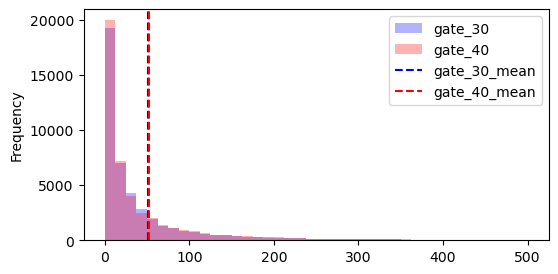

In [10]:
test_df = df_clean.copy()

A = test_df[test_df['version']=='gate_30']['sum_gamerounds']
B = test_df[test_df['version']=='gate_40']['sum_gamerounds']
print(f'Mean for gate_30 = {A.mean()}')
print(f'Mean for gate_40 = {B.mean()}')
print('Means are pretty much similar, had to offset +1 on B mean to make it visually different')

plt.figure(figsize=(6,3))
A.plot(kind='hist', bins=40, range=(0,500), color='blue', alpha=0.3, label='gate_30')
B.plot(kind='hist', bins=40, range=(0,500), color='red', alpha=0.3, label='gate_40')
plt.axvline(A.mean(), color='blue', linestyle='dashed', label='gate_30_mean')
plt.axvline(B.mean() + 1, color='red', linestyle='dashed', label='gate_40_mean')
plt.legend()
plt.show()

### Shapiro Wilkes Test for Normality
- Evaluates how closely the distribution of data resembles a theoretical normal distribution: By Comparing the ordered values of your data to the expected values under normality. Usese correlation like metric to quantify this similarity
- H_0: Distribution is Normal
- H_A: Distribution is not Normal

In [11]:
print('A results', shapiro(A))
print('B results', shapiro(B))

A results ShapiroResult(statistic=0.48864299058914185, pvalue=0.0)
B results ShapiroResult(statistic=0.4825664758682251, pvalue=0.0)


Both Distributions are NOT NORMAL! 
- A -> pvalue=0.0 < test-statistic=0.4886
- B -> pvalue=0.0 < test-statistic=0.4826

Because both A & B are NOT NORMAL, we must use **Non-Parametric Test**

### Mann-Whitney U Test
- Non-Parametric Test

A = gate_30
B = gate_40

In [12]:
print('HO: P(A > B) = P(B > A)')
print('P of random value from one group being greater than a random value from other group is equal')
print('HA: P(A > B) != P(B > A)')
print('Two groups come from different distributions')

stats.mannwhitneyu(A, B, alternative='two-sided')

HO: P(A > B) = P(B > A)
P of random value from one group being greater than a random value from other group is equal
HA: P(A > B) != P(B > A)
Two groups come from different distributions


MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

In [13]:
print('H0: P(A>=B)')
print('HA: P(A>B)')

stats.mannwhitneyu(A, B, alternative='greater')

H0: P(A>=B)
HA: P(A>B)


MannwhitneyuResult(statistic=1024285761.5, pvalue=0.02544577639572688)